In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import string as string
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder

from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
# uncomment if required
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')
# nltk.download('wordnet')

### Getting Real about Fake News dataset

In [2]:
df = pd.read_csv('fake.csv')

# Data Preparation and Cleaning

Checking how many null entries in each column

In [3]:
df.isnull().sum()

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64

Zooming in on "country" column, "US" is the most common entry

In [4]:
df.country.value_counts()

US    10367
GB      831
RU      400
DE      224
FR      207
TV      201
EU      112
CA      103
IS      100
ES      100
NL       55
ME       34
IN       23
BG       19
CO       17
LI       10
IR        7
EE        4
ZA        3
SG        2
IO        1
SE        1
AU        1
CH        1
Name: country, dtype: int64

Filling null entries in "country" column with "US" as it is the most common

In [5]:
df.country.fillna("US", inplace=True)

Remove countries that have less than 20 entries

In [6]:
value_counts = df.country.value_counts()
to_remove = value_counts[value_counts<20].index
df.replace(to_remove, np.nan, inplace = True)

In [7]:
df.language.value_counts()

english       12403
russian         203
spanish         172
german          111
french           38
arabic           22
portuguese       11
turkish          10
italian           9
ignore            7
greek             4
dutch             3
norwegian         3
finnish           1
chinese           1
polish            1
Name: language, dtype: int64

Remove all non-english entries as there are too few

In [8]:
df = df[df.language == 'english']

Dropping columns that will not be used in EDA and ML

In [9]:
df = df.drop(['uuid', 'language', 'crawled', 'published', 'ord_in_thread', 'domain_rank', 'main_img_url', 'thread_title'], axis = 1)

Removing rows with missing values

In [10]:
df = df.dropna()

# Exploratory Data Analysis

## Correlation matrix for numerical attributes

<AxesSubplot:title={'center':'Correlation Matrix'}>

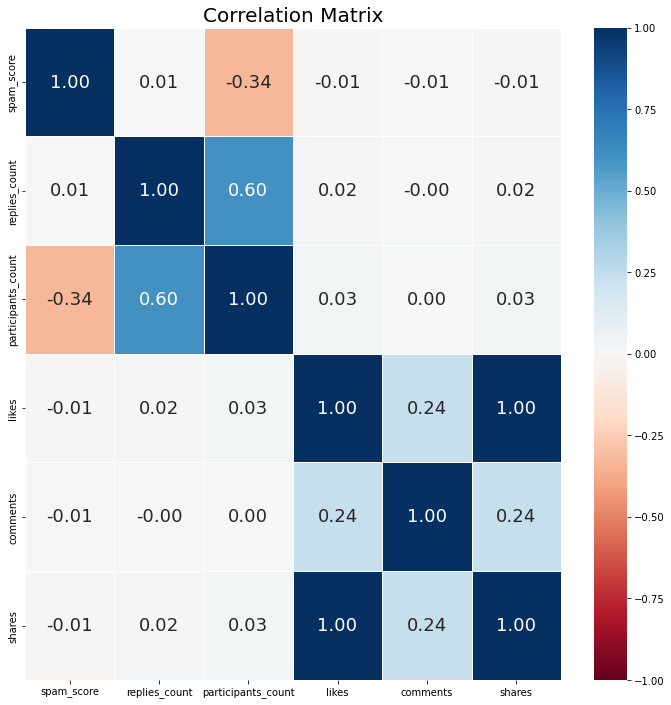

In [11]:
corrData = pd.DataFrame(df[['spam_score', 'replies_count', 'participants_count', 'likes', 'comments', 'shares']])

corrData = pd.concat([corrData, df["spam_score"]], axis = 1).reindex(df.index)

f = plt.figure(figsize=(12, 12))
plt.title('Correlation Matrix', fontsize=20)

sb.heatmap(df.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

The correlation plot shows that the participants_count has the strongest negative correlation. This suggests that the more participants for a given news thread, the higher the chances that it is not fake.

Variables that measure more participation and engagement could be used to predict news as not fake.

## Distribution of spam_score

<AxesSubplot:>

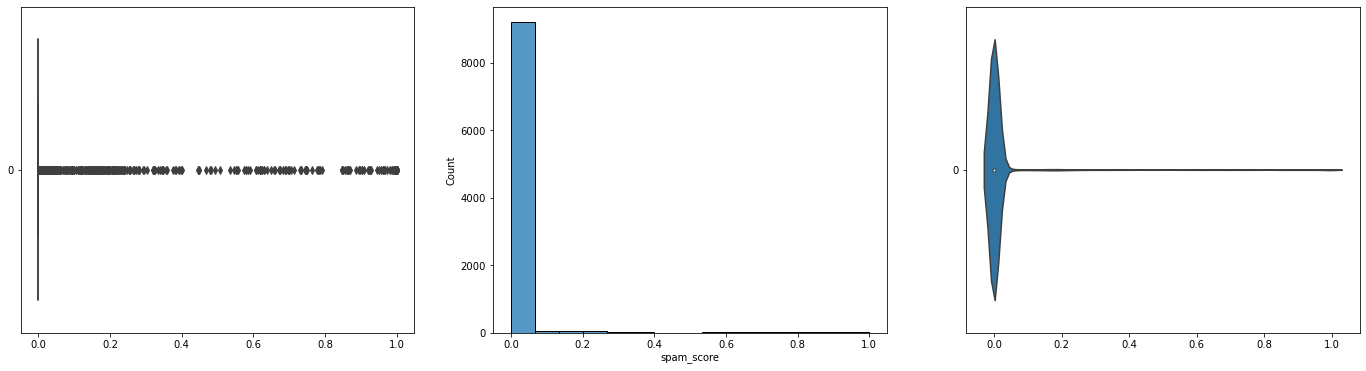

In [12]:
#Too many 0s for spam_score

f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = df.spam_score, orient = "h", ax = axes[0])
sb.histplot(data = df.spam_score, ax = axes[1])
sb.violinplot(data = df.spam_score, orient = "h", ax = axes[2])

Positively skewed

Remove 0 rows in spam_score to eliminate skewness

In [13]:
df = df[df.spam_score != 0]
spam = pd.DataFrame(df['spam_score'])

<AxesSubplot:>

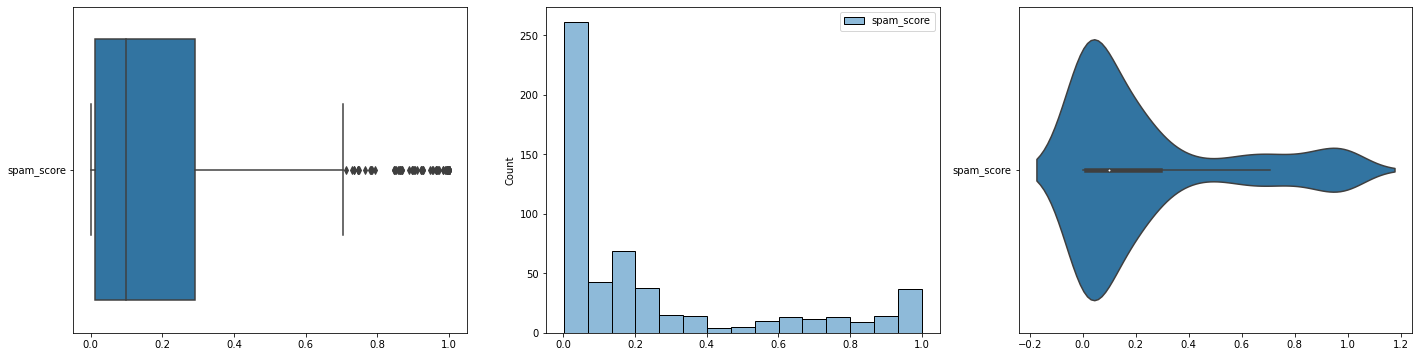

In [14]:
f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = spam, orient = "h", ax = axes[0])
sb.histplot(data = spam, ax = axes[1])
sb.violinplot(data = spam, orient = "h", ax = axes[2])

New distribution

Converting values of spam_score from numeric to categorical where 
spam_score <= 0.3 is changed to 'low'
0.3 < spam_score <= 0.6 is changed to 'medium'
spam_score > 0.6 is changed to 'high'

In [15]:
df.loc[(df.spam_score <= 0.3) & (df.spam_score > 0), 'spam_score'] = 0.3
df.loc[(df.spam_score > 0.3) & (df.spam_score <= 0.6), 'spam_score'] = 0.6
df.loc[(df.spam_score > 0.6), 'spam_score'] = 1

df.loc[(df.spam_score == 0.3), 'spam_score'] = 'low'
df.loc[(df.spam_score == 0.6), 'spam_score'] = 'medium'
df.loc[(df.spam_score == 1), 'spam_score'] = 'high'

df["spam_score"] = df["spam_score"].astype('category')

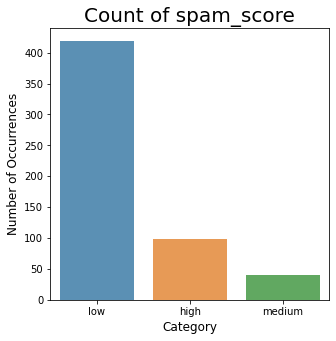

In [16]:
a = df["spam_score"].value_counts()
plt.figure(figsize=(5,5))
sb.barplot(x=a.index, y=a.values, alpha=0.8, order = a.index)
plt.title('Count of spam_score', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

## Spam frequency by authors

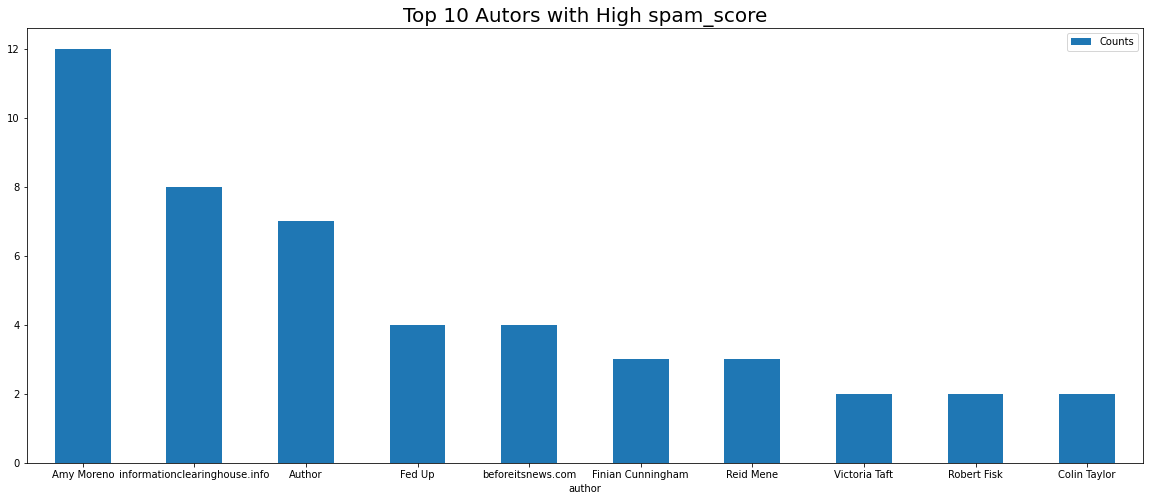

In [17]:
spamHigh = df[df['spam_score']=='high']
s = pd.DataFrame(spamHigh.value_counts('author'))
s = s.head(10)
s = s.reset_index()

ax = s.plot.bar(x='author', y=0, rot=0, figsize=(20,8), label='Counts').set_title('Top 10 Autors with High spam_score', fontsize=20)

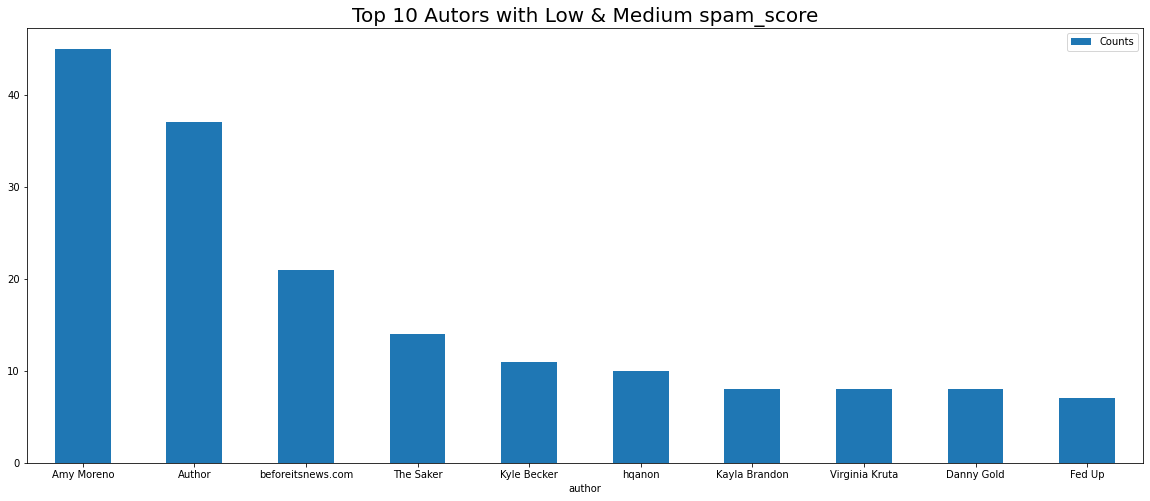

In [18]:
spamNotHigh = df[df['spam_score']!='high']
s = pd.DataFrame(spamNotHigh.value_counts('author'))
s = s.head(10)
s = s.reset_index()

ax = s.plot.bar(x='author', y=0, rot=0, figsize=(20,8), label='Counts').set_title('Top 10 Autors with Low & Medium spam_score', fontsize=20)

Author "Amy Moreno" appears at the top for both the high, and the low-medium category. Other unnamed writers that include “author” can also be seen in both of the group.

"informationclearinghouse.info" is seen in the high category but not in the low-medium category. It is potentially a fake news site.

## Title effect on spam score

In [19]:
#stop_words are the words that we ignore
 
stop_words = stopwords.words("english")

#function to tokenize text and remove stopwords, punctuations, non ascii characters

def stemmer(txt):
    txt=txt.lower()
    words = word_tokenize(txt)
    words = [w for w in words if w.isalpha()]
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isascii()]
    return( " ".join(words ))

In [20]:
df["title_stemmed"] = df["title"].apply(stemmer)

In [21]:
txt = df["title_stemmed"].tolist()
vectorizer = TfidfVectorizer()
vectorizer.fit(txt)

# dictionary of all the words in title can use to analyse with bar chart with high spam score
mydict = vectorizer.vocabulary_

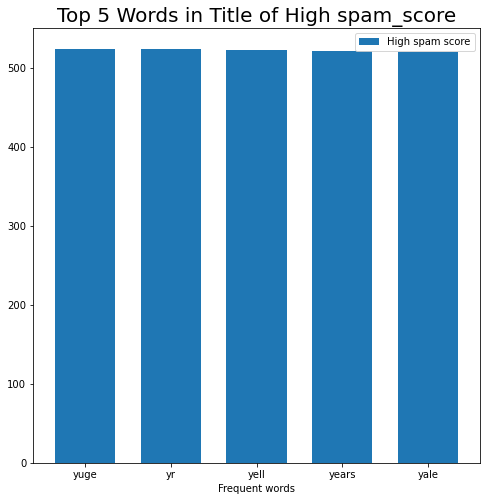

In [22]:
spamHigh = df[df['spam_score']=='high']

txt2 = spamHigh["title_stemmed"].tolist()
vectorizer = TfidfVectorizer()
vectorizer.fit(txt2)

mydict2 = vectorizer.vocabulary_

import operator
mydict2 = dict( sorted(mydict2.items(), key=operator.itemgetter(1),reverse=True))

rslt = pd.DataFrame(Counter(mydict2).most_common(5), columns=['Frequent words', 'High spam score']).set_index('Frequent words')
rslt.plot.bar(rot=0, figsize=(8,8), width=0.7)
plt.title('Top 5 Words in Title of High spam_score', fontsize=20)
plt.show()

Titles of news articles can be used as click-bait. The titles of news threads with high spam_score contains such words that fit the description of click-bait. These include World War 3, or "yuge" which is Donald Trump's way of saying the word "huge". There is a possible relationship between fake news and politics and current affairs.

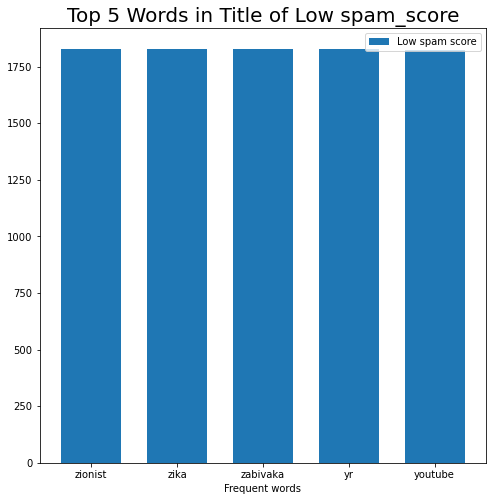

In [23]:
spamLow = df[df['spam_score']=='low']

txt2 = spamLow["title_stemmed"].tolist()
vectorizer = TfidfVectorizer()
vectorizer.fit(txt2)

mydict2 = vectorizer.vocabulary_

import operator
mydict2 = dict( sorted(mydict2.items(), key=operator.itemgetter(1),reverse=True))

rslt = pd.DataFrame(Counter(mydict2).most_common(5), columns=['Frequent words', 'Low spam score']).set_index('Frequent words')
rslt.plot.bar(rot=0, figsize=(8,8), width=0.7)
plt.title('Top 5 Words in Title of Low spam_score', fontsize=20)
plt.show()

## Country wise frequency

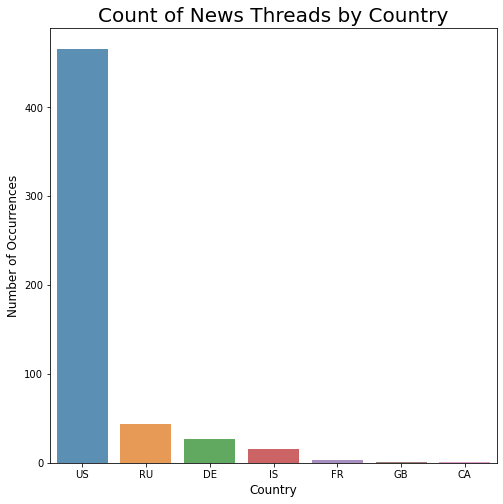

In [24]:
a = df["country"].value_counts()
plt.figure(figsize=(8,8))
sb.barplot(x=a.index, y=a.values, alpha = 0.8)
plt.title('Count of News Threads by Country', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Country', fontsize = 12)
plt.show()

Most of the news threads come from US

## Punctuation Marks in Title

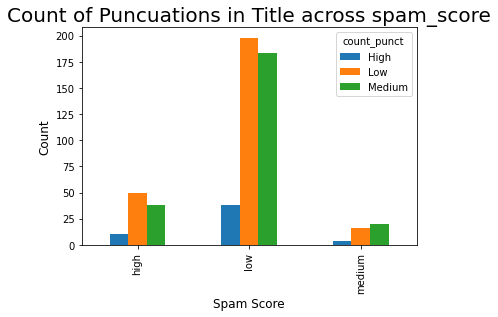

In [25]:
temp_df = pd.DataFrame()
temp_df["title"] = df["title"]
temp_df["spam_score"] = df["spam_score"]
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
temp_df['count_punct'] = df.title.apply(lambda s: count(s, string.punctuation))

temp_df.loc[(temp_df.count_punct <=1), 'count_punct'] = 1
temp_df.loc[(temp_df.count_punct >1) & (temp_df.count_punct <=4), 'count_punct'] = 2
temp_df.loc[(temp_df.count_punct >4), 'count_punct'] = 3

temp_df.loc[(temp_df.count_punct == 1), 'count_punct'] = 'Low'
temp_df.loc[(temp_df.count_punct == 2), 'count_punct'] = 'Medium'
temp_df.loc[(temp_df.count_punct == 3), 'count_punct'] = 'High'
    
temp_df = temp_df.groupby(['spam_score', 'count_punct']).size()
temp_df = temp_df.unstack()
temp_df.plot(kind='bar')

plt.ylabel('Count', fontsize = 12)
plt.xlabel('Spam Score', fontsize = 12)
plt.title('Count of Puncuations in Title across spam_score', fontsize=20)
plt.show()

Titles that have less puncuations have a low spam score, medium spam score has average puncuations. Titles with high spam score lie in the mixed range.

## Spam frequency by URL

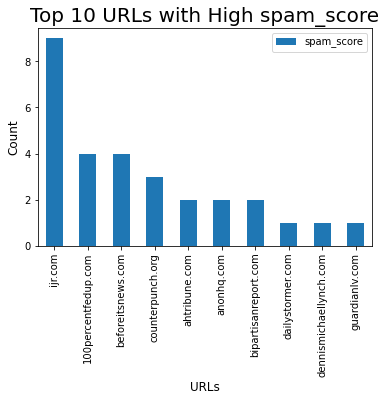

In [26]:
tempURL_df = pd.DataFrame()
tempURL_df["site_url"] = df["site_url"]
tempURL_df["spam_score"] = df["spam_score"]

tempURL_df = tempURL_df[tempURL_df['spam_score'] == 'high']
count_df = tempURL_df.groupby(['site_url']).count()

count_df = pd.DataFrame(count_df).head(10)

count_df = count_df.sort_values('spam_score', ascending=False)
count_df.plot(kind='bar')
plt.ylabel('Count', fontsize = 12)
plt.xlabel('URLs', fontsize = 12)
plt.title('Top 10 URLs with High spam_score', fontsize=20)
plt.show()

ijr.com has the most number of high spam_score. The website or the writers on the website could be spreaders of fake news.

## Spam frequency by engagement

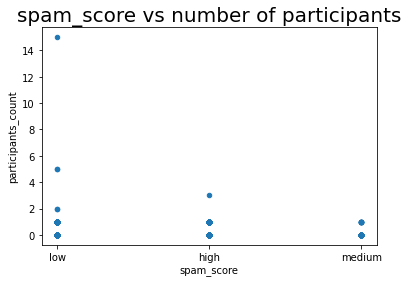

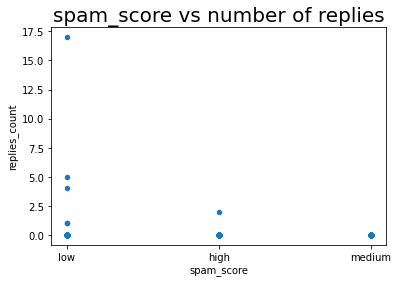

In [27]:
df.plot.scatter(x='spam_score', y='participants_count').set_title("spam_score vs number of participants", fontsize=20)
df.plot.scatter(x='spam_score', y='replies_count').set_title("spam_score vs number of replies", fontsize=20)
plt.show()

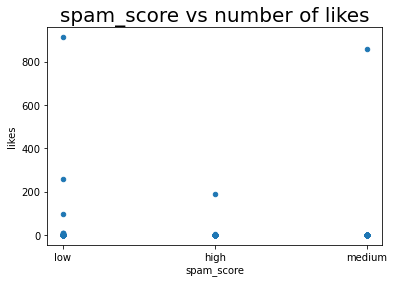

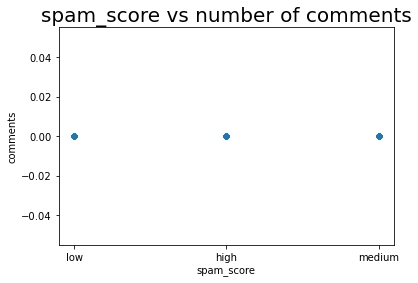

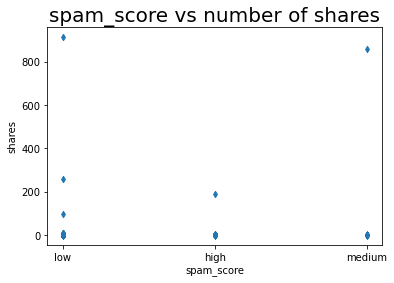

In [28]:
df.plot.scatter(x='spam_score', y='likes').set_title("spam_score vs number of likes", fontsize=20)
df.plot.scatter(x='spam_score', y='comments').set_title("spam_score vs number of comments", fontsize=20)
df.plot.scatter(x='spam_score', y='shares', marker='d').set_title("spam_score vs number of shares", fontsize=20)
plt.show()

Engagement and participants are lower for high spam_score compared to low and medium, with the exception of number of comments which is consistent among the 3 categories of spam_score.

## Machine Learning

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from scipy.sparse import hstack

In [30]:
vectorizer = TfidfVectorizer(max_df = 0.7, ngram_range = (1,3))

In [31]:
# combine title and text, TFIDF matrix

df["text_stemmed"] = df["text"].apply(stemmer)

title_matrix = vectorizer.fit_transform(df["title_stemmed"])
text_matrix = vectorizer.fit_transform(df["text_stemmed"])

print(pd.DataFrame(text_matrix.todense(), columns = vectorizer.get_feature_names()))

     aae  aae active  aae active members  aae since  aae since distanced  aaj  \
0    0.0         0.0                 0.0        0.0                  0.0  0.0   
1    0.0         0.0                 0.0        0.0                  0.0  0.0   
2    0.0         0.0                 0.0        0.0                  0.0  0.0   
3    0.0         0.0                 0.0        0.0                  0.0  0.0   
4    0.0         0.0                 0.0        0.0                  0.0  0.0   
..   ...         ...                 ...        ...                  ...  ...   
552  0.0         0.0                 0.0        0.0                  0.0  0.0   
553  0.0         0.0                 0.0        0.0                  0.0  0.0   
554  0.0         0.0                 0.0        0.0                  0.0  0.0   
555  0.0         0.0                 0.0        0.0                  0.0  0.0   
556  0.0         0.0                 0.0        0.0                  0.0  0.0   

     aaj district  aaj dist

In [32]:
dictvector = DictVectorizer()
categorical_matrix = dictvector.fit_transform(df[['author','site_url','country']].to_dict('records'))
onehot = OneHotEncoder()
categorical_matrix = onehot.fit_transform(categorical_matrix.toarray()).toarray()

combined_matrix = hstack([title_matrix, text_matrix, categorical_matrix])

In [33]:
# split into train and test

y = df['spam_score']
x_train, x_test, y_train, y_test = train_test_split(combined_matrix, y, test_size = 0.3, stratify=y, random_state=6)

Optimal K-value: 12


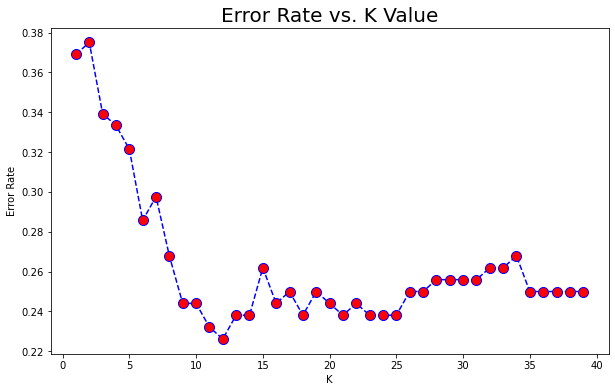

In [34]:
# Machine Learning Model - K Nearest Neighbours

error_rate = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    y_predict = knn.predict(x_test)
    knn_score = knn.score(x_test, y_test)
    error_rate.append(np.mean(y_predict != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value', fontsize=20)
plt.xlabel('K')
plt.ylabel('Error Rate')

k = error_rate.index(min(error_rate)) + 1
print('Optimal K-value:', k)

              precision    recall  f1-score   support

        high       0.80      0.13      0.23        30
         low       0.77      0.99      0.87       126
      medium       1.00      0.08      0.15        12

    accuracy                           0.77       168
   macro avg       0.86      0.40      0.42       168
weighted avg       0.79      0.77      0.70       168

Accuracy:  0.7738095238095238


[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Actual')]

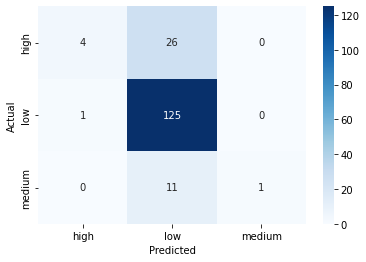

In [35]:
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)
knn_score = knn.score(x_test, y_test)

print(classification_report(y_test, y_predict))
print('Accuracy: ', knn_score)
c = confusion_matrix(y_test, y_predict)
matrix = sb.heatmap(c, annot = True, fmt = 'd', cmap = 'Blues', 
                    xticklabels = ['high', 'low', 'medium'], yticklabels = ['high', 'low', 'medium'])
matrix.set(xlabel='Predicted', ylabel='Actual')